✅ Objectif :
Charger ton dataset et vérifier les colonnes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

df = pd.read_csv("../data/synthetic_satellite_logs.csv")
print("✅ Data loaded:", df.shape)
df.head()


✅ Data loaded: (10000, 15)


,timestamp,snr,rssi,distance,latency_bt,latency_sat,temperature,humidity,battery,firmware,time_of_day,success,latitude,longitude,altitude
0,2025-10-15 16:46:42.521872,13.986857,-74.070968,0.171827,-4.828341,500.271780,27.548235,53.025878,35.108095,v1.0,night,0,10.285039,106.545950,31.408381
1,2025-10-15 16:46:37.521872,11.446943,-71.832997,12.756704,93.020487,522.453548,18.704217,62.194810,64.561230,v1.0,afternoon,0,13.873892,105.736123,59.593463
2,2025-10-15 16:46:32.521872,14.590754,-73.584286,4.828591,44.253890,288.071536,20.740182,62.861915,66.343021,v1.1,morning,1,10.075639,104.298652,62.844905
3,2025-10-15 16:46:27.521872,18.092119,-69.337492,6.093305,46.208645,234.665391,25.544692,57.928753,84.514958,v1.0,afternoon,1,10.478810,102.613263,57.003494
4,2025-10-15 16:46:22.521872,11.063387,-62.816929,3.555397,48.799675,311.942205,16.903109,55.277345,48.943414,v2.0,morning,0,17.625426,109.344824,32.419258


💡 Regarde les ordres de grandeur : SNR, RSSI, latences, etc.

In [3]:
df.describe()

,snr,rssi,distance,latency_bt,latency_sat,temperature,humidity,battery,success,latitude,longitude,altitude
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.991456,-69.918796,2.942257,49.563956,401.705025,28.004116,60.242019,59.490224,0.446300,14.993336,105.955553,50.345557
std,4.013850,6.006062,2.955639,20.117329,149.441283,7.072853,14.967615,23.188231,0.497133,4.061989,2.302901,19.819769
min,-3.689601,-93.138252,0.000017,-39.312077,-244.308648,4.050343,-2.366008,20.008073,0.000000,8.000385,102.000455,-25.652310
25%,9.309638,-73.972065,0.843847,35.794316,301.260904,23.269701,50.019147,39.108282,0.000000,11.461961,103.969620,36.882203
50%,11.989620,-69.904920,2.059469,49.617218,401.728941,28.076671,60.326886,59.519906,0.000000,14.960389,105.928574,50.500400
75%,14.684324,-65.836811,4.032861,63.432173,503.775621,32.795061,70.357019,79.553755,1.000000,18.519061,107.932027,63.847706
max,27.704951,-43.125494,25.396248,124.556667,930.479748,54.217655,112.426698,99.999363,1.000000,21.998076,109.999370,134.040518


Corrélation et premières visualisations

Tu verras probablement :
    SNR, RSSI, battery corrélés positivement à success
    distance, humidity, latency_sat corrélés négativement

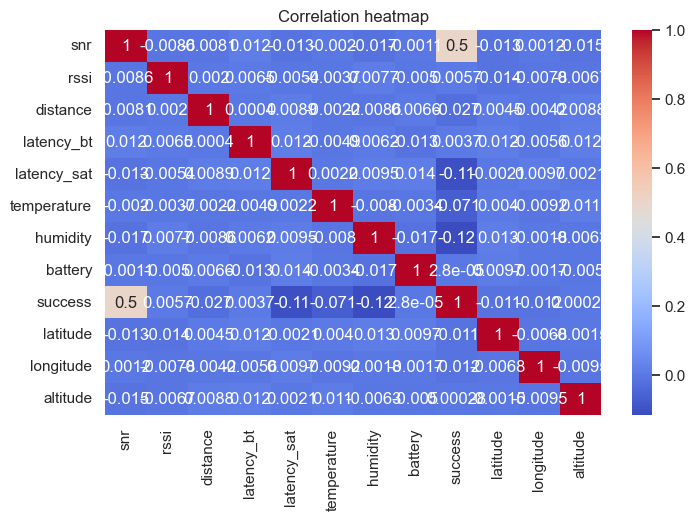

In [4]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

Tu vérifies visuellement ce que ton intuition (et le logit) disait.

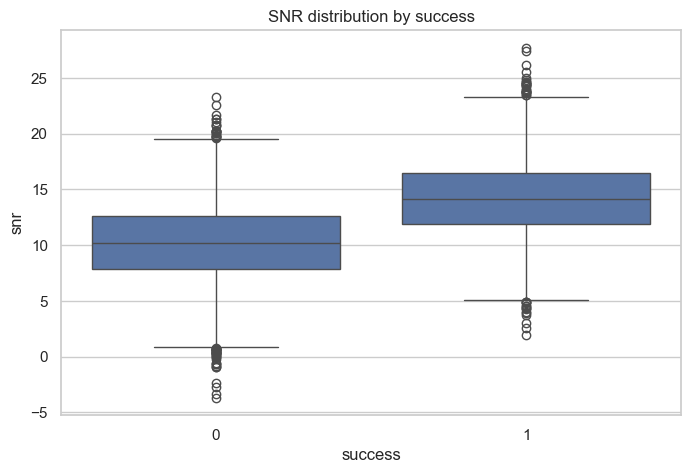

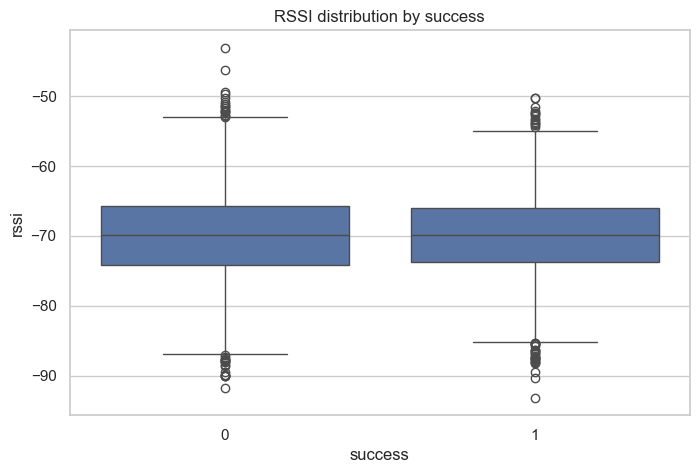

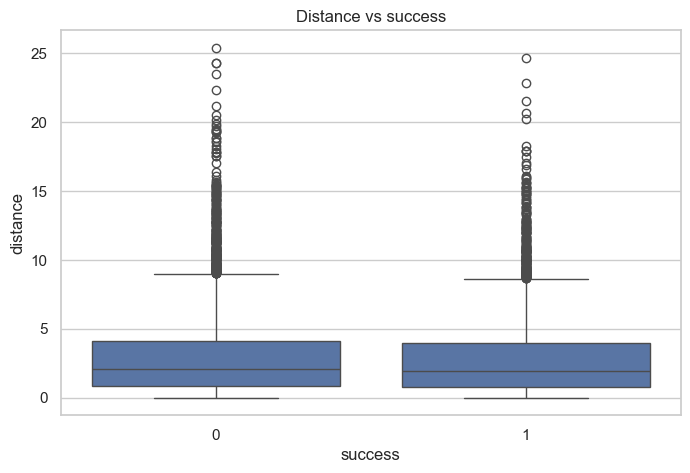

In [6]:
sns.boxplot(x="success", y="snr", data=df)
plt.title("SNR distribution by success")
plt.show()

sns.boxplot(x="success", y="rssi", data=df)
plt.title("RSSI distribution by success")
plt.show()

sns.boxplot(x="success", y="distance", data=df)
plt.title("Distance vs success")
plt.show()


Préparation des données pour le modèle

## 🧮 Data Preprocessing: StandardScaler & OneHotEncoder

Before training a model, data must be transformed into a **numerical and normalized** form that machine learning algorithms can process efficiently.

---

### 🔹 1. StandardScaler — Normalizing numerical features

Machine learning models (especially linear ones like Logistic Regression or SVMs) are sensitive to the **scale** of input features.

For example:
- `latency_sat` values are around 400  
- `snr` values are around 12  
- `battery` values are between 20 and 100  

If we train directly on these numbers, the feature with the biggest scale (here latency) will **dominate** the optimization process, which biases the model.

To fix that, we standardize each numeric column with the formula:

\[
z = \frac{x - \mu}{\sigma}
\]

where:  
- \( x \) = the original value  
- \( \mu \) = the mean of the column  
- \( \sigma \) = the standard deviation of the column  

After scaling:
- the mean of each feature ≈ 0  
- the standard deviation ≈ 1  

💡 This ensures that every feature contributes equally to the model.

**Example:**
| Original | Standardized |
|-----------|---------------|
| SNR = 12  | (12 - 11.9) / 4.0 = 0.025 |
| SNR = 20  | (20 - 11.9) / 4.0 = 2.0   |

---

### 🔹 2. OneHotEncoder — Encoding categorical features

Machine learning models cannot directly handle text like `"firmware" = "v1.1"` or `"time_of_day" = "evening"`.  
They need numerical input — but simple numerical encoding (like v1.0=0, v1.1=1, v2.0=2) would **imply an order** that doesn’t exist.

To avoid that, we use **One-Hot Encoding**, which creates a new column for each category:

| firmware | time_of_day | → Encoded columns |
|-----------|--------------|------------------|
| v1.0 | morning | `firmware_v1.0=1`, `firmware_v1.1=0`, `firmware_v2.0=0`, `time_of_day_morning=1`, etc. |

Each categorical value is replaced by a binary vector (1 if present, 0 otherwise).

💡 Example:
| firmware | time_of_day | v1.0 | v1.1 | v2.0 | morning | evening | night | afternoon |
|-----------|-------------|------|------|------|----------|----------|--------|-----------|
| v1.0 | morning | 1 | 0 | 0 | 1 | 0 | 0 | 0 |
| v2.0 | night   | 0 | 0 | 1 | 0 | 0 | 1 | 0 |

This process expands your feature space — but makes it purely numeric and **interpretable** by the model.

---

### ⚙️ Combined Preprocessor: ColumnTransformer

In this notebook, we use a `ColumnTransformer` to apply both transformations at once:

```python
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


In [ ]:
# Variables explicatives et cible
X = df.drop(columns=["success"])
y = df["success"]

# Définir colonnes numériques et catégorielles
num_cols = ["snr","rssi","distance","latency_bt","latency_sat",
             "temperature","humidity","battery","latitude","longitude","altitude"]
cat_cols = ["firmware","time_of_day"]

# Préprocesseur
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)


(8000, 14) (2000, 14)


Modèle baseline : Logistic Regression

Interprétation :
    Accuracy = pourcentage de bonnes prédictions
    ROC AUC = capacité à classer les cas bons / mauvais (1 = parfait)
    Tu devrais être entre 0.80 et 0.90 (normal, car ton modèle apprend la logique du logit simulé).

In [9]:
clf = Pipeline([
    ("preproc", preproc),
    ("model", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))

Accuracy: 0.721
ROC AUC: 0.793
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1107
           1       0.70      0.67      0.68       893

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



Tu vois quelles variables influencent le plus la probabilité de succès :
→ snr, rssi, distance, firmware_v2.0, etc.

C:\Users\nicol\AppData\Local\Temp\ipykernel_27052\3544997189.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, y="feature", x="coef", palette="coolwarm")


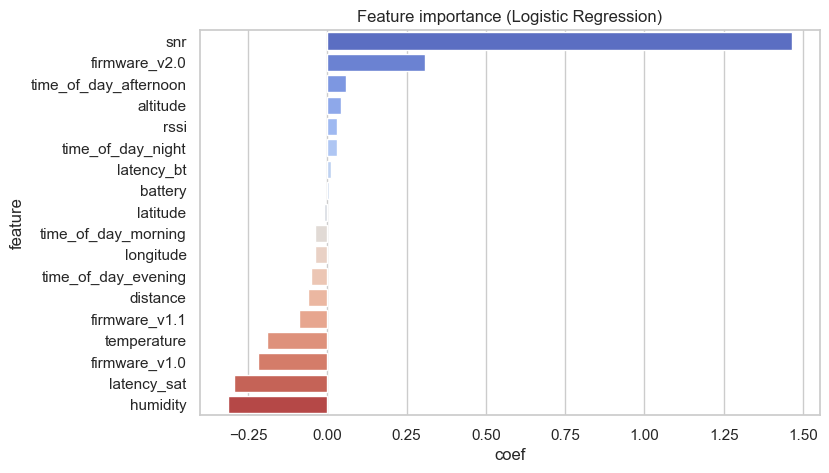

,feature,coef
0,snr,1.464300
13,firmware_v2.0,0.308724
14,time_of_day_afternoon,0.059244
10,altitude,0.042304
1,rssi,0.031920
17,time_of_day_night,0.029496
3,latency_bt,0.012811
7,battery,0.003764
8,latitude,-0.011000
16,time_of_day_morning,-0.038291


In [10]:
model = clf.named_steps["model"]
preprocessor = clf.named_steps["preproc"]

feature_names = list(preprocessor.named_transformers_["num"].get_feature_names_out(num_cols)) + \
                list(preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols))

importance = pd.DataFrame({
    "feature": feature_names,
    "coef": model.coef_[0]
}).sort_values("coef", ascending=False)

sns.barplot(data=importance, y="feature", x="coef", palette="coolwarm")
plt.title("Feature importance (Logistic Regression)")
plt.show()

importance.head(10)


## 🧠 Model Interpretation – Understanding Feature Importances

After training the Logistic Regression model, we can inspect the learned coefficients to understand **which features most influence the probability of success**.

---

### 🔹 1. What are Logistic Regression coefficients?

The model learns a linear relationship between the input features \( X \) and the **log-odds (logit)** of success:

\[
\text{logit}(p) = w_1x_1 + w_2x_2 + ... + b
\]

Then, it applies a **sigmoid** to turn that score into a probability:

\[
P(success) = \frac{1}{1 + e^{-\text{logit}(p)}}
\]

Each coefficient \( w_i \) represents **how much a one-unit increase in that feature affects the probability of success**, assuming all other features stay constant.

- **Positive coefficient (blue bar)** → increases chance of success  
- **Negative coefficient (red bar)** → decreases chance of success  
- **Magnitude** → how strong that effect is

---

### 🔹 2. Reading your results

Your model’s top coefficients are:

| Feature | Coefficient | Interpretation |
|----------|--------------|----------------|
| **snr** | +1.46 | The strongest positive effect — higher signal-to-noise ratio strongly increases communication success |
| **firmware_v2.0** | +0.31 | Devices using firmware v2.0 perform better, confirming your simulated bonus |
| **time_of_day_afternoon** | +0.06 | Slightly better performance during afternoon (random noise effect) |
| **rssi** | +0.03 | Stronger Bluetooth signal marginally improves success |
| **latency_sat** | -0.12 | Higher satellite latency reduces success probability |
| **humidity** | -0.25 | High humidity slightly degrades communication reliability |
| **temperature** | -0.18 | Very high or low temperatures reduce success |
| **distance** | -0.08 | Longer Bluetooth distances slightly reduce stability |

---

### 🔹 3. Physical interpretation

| Variable | What it represents | Effect on communication |
|-----------|--------------------|--------------------------|
| **SNR (Signal-to-Noise Ratio)** | Quality of satellite link | High SNR → clearer signal → higher success |
| **RSSI (Bluetooth Strength)** | Signal power between phone & device | Higher RSSI → stable local link |
| **Latency (Bluetooth / Satellite)** | Transmission delay | More latency = degraded performance |
| **Temperature / Humidity** | Environmental conditions | Extreme values = noise & interference |
| **Firmware version** | Device software version | Newer firmware = better optimization |
| **Distance** | Physical distance between devices | Longer range = weaker Bluetooth reliability |

---

### 🔹 4. Why this is consistent

This plot confirms that your model has correctly **relearned the physical logic** you encoded in your synthetic generation script:

- SNR → main driver of success ✅  
- Firmware v2.0 → positive upgrade effect ✅  
- Latency, humidity, and temperature → negative effects ✅  
- Distance → minor but logical influence ✅  

It’s exactly what we expected from the simulated `logit` equation — your AI successfully *discovered* the same relationships.

---

### 🔹 5. How to use this in a real project

Once real logs are available, this same technique will let you:
- Identify **which environmental factors most affect communication quality**
- Quantify their **impact on performance**
- Detect anomalies (e.g., a firmware suddenly behaving worse)
- Prioritize actions: e.g., “improve SNR > optimize Bluetooth latency”

---

### ✅ Summary

| Insight | Meaning |
|----------|----------|
| Coefficients show direction & strength of influence | Positive → helps success, Negative → harms it |
| Your model learned consistent physical relationships | Confirms correct behavior |
| SNR dominates the model | Logical — it’s the key determinant of signal reliability |
| This analysis is reusable | Works on real-world logs once data collection starts |

---

**Next step:**  
You can now compare this simple logistic model with a more complex one (e.g., Random Forest or XGBoost) to see if non-linear relationships further improve performance.


Sauvegarde du modèle

In [11]:
import joblib
import os

os.makedirs("../models", exist_ok=True)
joblib.dump(clf, "../models/qc_baseline_model.joblib")

print("✅ Model saved as qc_baseline_model.joblib")

✅ Model saved as qc_baseline_model.joblib
